# Odtworzenie środowiska z poprzednich zajęć



In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from keras.callbacks import LambdaCallback

np.set_printoptions(suppress=True)
print(tf.__version__)

2.11.0


In [2]:
rng = np.random.default_rng(2023)

In [3]:
data = pd.DataFrame(
    data=np.hstack((
        rng.normal(100, 10, size=(100, 1)),
        rng.normal(50, 5, size=(100, 1)),
        rng.normal(200, 20, size=(100, 1)),
        rng.normal(0, 5, size=(100, 1))
    )),
    columns=["X1", "X2", "X3", "e"]
)

data["Y"] = 150 - 4*data.X1 + 2.5*data.X2 + data.e

In [4]:
random_tensor = tf.random.normal((3,), seed=2023)
random_tensor

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([ 0.3747068 ,  0.72808206, -0.7266839 ], dtype=float32)>

In [5]:
model2 = tf.keras.Sequential()

model2.add(tf.keras.Input(shape=(3,)))

model2.add(
    tf.keras.layers.Dense(
        1, 
        activation=tf.keras.activations.linear,
        kernel_initializer=tf.keras.initializers.Constant(random_tensor)
    )
)

In [6]:
print_weights = LambdaCallback(on_epoch_end=lambda batch, logs: print(model2.layers[0].get_weights()))

In [7]:
model2.compile(optimizer='sgd', loss='mse')

In [8]:
history = model2.fit(
    data.loc[:, ["X1", "X2", "X3"]], 
    data.loc[:, ["Y"]], 
    epochs=5, 
    verbose=1, 
    callbacks = [print_weights], 
    batch_size=20, 
    shuffle=False
)

Epoch 1/5
1/5 [=====>........................] - ETA: 0s - loss: 3959.8340[array([[-1.2303229e+14],
       [-5.9723894e+13],
       [-2.5334207e+14]], dtype=float32), array([-1.1953204e+12], dtype=float32)]
5/5 [==============================] - 0s 3ms/step - loss: 720715545338429193886629888.0000
Epoch 2/5
1/5 [=====>........................] - ETA: 0s - loss: 4512195502842166485036003114352640.0000[array([[1.8160138e+29],
       [8.8155220e+28],
       [3.7394456e+29]], dtype=float32), array([1.7643484e+27], dtype=float32)]
5/5 [==============================] - 0s 2ms/step - loss: inf                                
Epoch 3/5
1/5 [=====>........................] - ETA: 0s - loss: inf[array([[nan],
       [nan],
       [nan]], dtype=float32), array([nan], dtype=float32)]
5/5 [==============================] - 0s 2ms/step - loss: nan
Epoch 4/5
1/5 [=====>........................] - ETA: 0s - loss: nan[array([[nan],
       [nan],
       [nan]], dtype=float32), array([nan], dtype=float3

# Co się stało podczas procesu uczenia sieci?

[Problem ekspoludjącego gradientu](https://en.wikipedia.org/wiki/Vanishing_gradient_problem)

# Zaimplementujemy `model2` od zera, używając jedynie pakietu numpy.

# algorytm Stochastic Gradient Descent - skrótowo

(dla pojedynczego *batch'a*)

1. zainicjuj wagi $W_0$,
2. oblicz ryzyko $L(W_0)$ na *batch'u*,
3. oblicz `grad` = $\nabla_W L(W_0)$ na *batch'u* (zastosuj operację uśredniania jeżeli \#batch > 1),
4. $W_1 = W_0 - \eta \cdot$ `grad`,
5. weź kolejny batch i wróć do kroku 2.

## Uwagi a propos konwencji

* W naszym prostym przypadku $W = (w_0, w_1, w_2, w_3)$ jest wektorem, ale częściej $W$ jest macierzą. To jedynie komplikuje obliczenia (chcemy wyrazić gradient funkcji straty względem $W$ także jako macierz), ale nie zmienia algorytmu SGD.


# Algorytm SGD krok po kroku.

# Krok 1. Zainicjuj $W_0$ (Zadanie 1)

Stwórz `model3`, używając `kernel_initializer=tf.keras.initializers.Constant(random_tensor)`, skompiluj model i wypisz wagi do konsoli.
Użyj algorytmu SGD z $\eta = 0.1$ i błędu średniokwadratowego jako funkcji ryzyka.

In [9]:
model3 = tf.keras.Sequential()

model3.add(tf.keras.Input(shape=(3,)))

model3.add(tf.keras.layers.Dense(
    1, 
    activation=tf.keras.activations.linear, 
    kernel_initializer=tf.keras.initializers.Constant(random_tensor)
))

weights = model3.layers[0].get_weights()

In [10]:
model3.compile(optimizer=tf.keras.optimizers.legacy.SGD(learning_rate=0.1), loss='mse')

In [11]:
print(weights)

[array([[ 0.3747068 ],
       [ 0.72808206],
       [-0.7266839 ]], dtype=float32), array([0.], dtype=float32)]


# Krok 2. Policz *ręcznie* $L(W_0)$ z modelu na batchu 20 obserwacji. (Zadanie 2)

Użyj metody `model3.predict`.

In [12]:
((model3.predict(data.loc[:19, ["X1", "X2", "X3"]]) - data.loc[:19, ["Y"]])**2).mean()

1/1 [==============================] - 0s 63ms/step


Y    3959.834132
dtype: float64

# Kroki 3 & 4 (Zadanie 3)

Używając biblioteki `Keras`,
3. Oblicz **grad** = $\nabla_W L(W_0)$.
4. Przypisz $W_1 = W_0 - \eta \cdot \:$ **grad**.

Przypomnijmy, że $\eta = 0.1$ w naszym przykładzie.

Użyjemy metody `model3.train_on_batch`, która dostarcza nam pełnej kontroli nad procesem trenowania sieci neuronowej w `Keras`.
[Link do dokumentacji Keras](https://keras.io/api/models/model_training_apis/).

In [13]:
model3.train_on_batch(data.loc[:19, ["X1", "X2", "X3"]], data.loc[:19, ["Y"]])

3959.833984375

Zauważ, że wywołanie `model3.train_on_batch()` zaktualizowało wagi zgodnie z algorytmem SGD. Model przechowuje w tej chwili wagi $W_1$. Wypisz te wagi do konsoli.

In [14]:
model3.layers[0].get_weights()

[array([[ -990.87396],
        [ -471.33658],
        [-1821.9396 ]], dtype=float32), array([-9.334723], dtype=float32)]

# Zadanie 4

Zaimplementuj kroki 3 oraz 4 używając jedynie pakietów `pandas` / `numpy`.

Wywołaj 1 batch update na pierwszych 20 obserwacjach ze zbioru `data`. Upewnij się, że rezultaty odpowiadają tym otrzymanym metodą `model3.train_on_batch` powyżej.

Dla przypomnienia: gradient funkcji straty $L(W) = MSE(W)$ w regresji liniowej:

\begin{equation}
\nabla_W L(W) = 
\nabla_W (X W - Y)^T (X W - Y) =
-2X^TY + 2X^TXW
\end{equation}

**Nie zapomnij o uwzględnieniu *bias* (wyrazu wolnego) w procesie optymalizacji!**

# Podpowiedzi

1. napisz funkcję `gradient(X, Y, W)` która zwróci gradient,
2. przygotuj **macierze** X, Y, $W_0$ (zadbaj o reshaping),
    * macierz $X$ powinna zawierać kolumnę jedynkową (użyj np. `np.c_`),
    * $W_0$ powinno zawierać na pierwszym miejscu wagę bias (użyj np. `np.insert`)
3. Uśrednij gradient wynikający z funkcji `gradient` (nie należy używać funkcji `np.mean` w naszej implementacji, bo funkcja `gradient` zwraca sumę gradientów dla całego batch'a; wystarczy zatem podzielić wynik funkcji `gradient` przez liczebnośc batch'a),
4. Oblicz zaktualizowane wagi `W_1` i porównaj z wynikiem z `model3`.
    

In [15]:
def gradient(X, Y, W):
    return -2 * (X.T @ Y) + 2 * (X.T @ X) @ W

Upewniajmy się zawsze w razie wątpliwości jaki jest typ zmiennej, z którą pracujemy. 

In [16]:
type(random_tensor)

tensorflow.python.framework.ops.EagerTensor

In [17]:
type(random_tensor.numpy())

numpy.ndarray

Dołączam wektor $\mathbf{1}$

In [18]:
X = np.c_[np.ones(20), data.loc[:19, ["X1", "X2", "X3"]].values]

In [19]:
X

array([[  1.        , 106.01721294,  44.2535498 , 206.1371387 ],
       [  1.        , 111.5161897 ,  48.86433667, 182.4535075 ],
       [  1.        ,  86.40537644,  40.69480846, 188.18419573],
       [  1.        , 102.22055335,  46.86829985, 233.65706516],
       [  1.        ,  92.24132455,  53.41883515, 238.72946119],
       [  1.        , 108.08705804,  59.89770438, 218.83238112],
       [  1.        ,  98.01371737,  47.51238022, 179.86595072],
       [  1.        ,  84.21306135,  50.78026367, 229.27440621],
       [  1.        ,  93.70710704,  56.11870979, 236.44811689],
       [  1.        ,  96.1224306 ,  54.32181677, 188.25640164],
       [  1.        , 100.50186186,  57.51083261, 174.17617595],
       [  1.        ,  90.92956358,  45.63474788, 226.85912449],
       [  1.        , 101.3213809 ,  51.58668344, 188.65357279],
       [  1.        , 114.04902491,  60.03540048, 188.64995013],
       [  1.        , 104.04102049,  40.45310352, 186.6445482 ],
       [  1.        ,  89

In [20]:
Y = data.loc[:19, "Y"].values

In [21]:
Y = data.loc[:19, "Y"].values.reshape(-1, 1)

In [22]:
Y

array([[-175.04080773],
       [-183.31978109],
       [ -97.98321232],
       [-149.28872408],
       [ -89.29307085],
       [-134.55170374],
       [-119.52272976],
       [ -60.7846754 ],
       [ -86.97875372],
       [ -90.78824945],
       [-108.92870377],
       [-103.12739469],
       [-127.5549782 ],
       [-155.29251275],
       [-157.74807006],
       [ -83.50108151],
       [ -91.85842871],
       [-169.28381553],
       [ -85.23126437],
       [-145.19474387]])

In [23]:
W_0 = random_tensor.numpy()

In [24]:
W_0

array([ 0.3747068 ,  0.72808206, -0.7266839 ], dtype=float32)

Dodajmy *bias* $w_0 = 0$ na początku `array` (odpowiada kolumnie jedynkowej w zbiorze danych $X$).

In [25]:
W_0 = np.insert(W_0, 0, 0)

In [26]:
W_0

array([ 0.        ,  0.3747068 ,  0.72808206, -0.7266839 ], dtype=float32)

In [27]:
W_0 = W_0.reshape(-1, 1)

In [28]:
W_0

array([[ 0.        ],
       [ 0.3747068 ],
       [ 0.72808206],
       [-0.7266839 ]], dtype=float32)

Obliczmy gradient.

In [29]:
gradient(X, Y, W_0)

array([[  1866.94484801],
       [198249.72540557],
       [ 94412.93060702],
       [364242.57030401]])

Uśrednijmy gradient.

In [30]:
gradient(X, Y, W_0) / 20

array([[   93.3472424 ],
       [ 9912.48627028],
       [ 4720.64653035],
       [18212.1285152 ]])

Wystarczy podzielić przez \#batch, czyli 20. Wynik funkcji `gradient(X, Y, W_0)` zaimplementowanej powyżej to suma gradientów dla 20 obserwacji.

## Porównajmy uaktualnione wagi z wynikami `model3.train_on_batch`

In [31]:
W_0 - 0.1 * ( gradient(X, Y, W_0)/20 )

array([[   -9.33472424],
       [ -990.87392022],
       [ -471.33657097],
       [-1821.93953543]])

In [32]:
model3.layers[0].get_weights()

[array([[ -990.87396],
        [ -471.33658],
        [-1821.9396 ]], dtype=float32), array([-9.334723], dtype=float32)]

Obserwujemy, że wyniki są zbieżne. Uwaga na konwencje:
1. dot. kształtu macierzy $W$ w `Keras` (w naszym przykładzie konwencja jest zbieżna, ale w sieciach z warstwami ukrytymi może się różnić),
2. dot. bias: w naszym przykładzie uwzględniliśmy go bezpośrednio w macierzy $W$, natomiast `Keras` traktuje bias osobno (co widać w rezultacie wywołania metody `get_weights()` powyżej).

# Zadanie 5

Powrót do problemu eksplodującego gradientu. Czy możemy jakoś przeciwdziałać temu problemowi?

Jeden sposób: użyjmy innego algorytmu optymalizacji, np. ADAM (Adaptive Moment Estimation).

In [33]:
model4 = tf.keras.Sequential()

model4.add(tf.keras.Input(shape=(3,)))

model4.add(tf.keras.layers.Dense(
    1, 
    activation=tf.keras.activations.linear, 
    kernel_initializer=tf.keras.initializers.Constant(random_tensor)
))

model4.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1), loss='mse')

Przypisuję wynik uczenia `model4.fit` do zmiennej `history`.

In [34]:
history = model4.fit(data.loc[:, ["X1", "X2", "X3"]], data.loc[:, ["Y"]], epochs=1000, batch_size=25, verbose=0)

In [35]:
type(history)

keras.callbacks.History

Wykreślmy historię uczenia się modelu.

Podstawowy pakiet do wizualizacji danych w Pythonie to `matplotlib` zaimportowany na górze notebooka.

Uznana konwencja w Pythonie to inicjalizacja pojedynczego wykresu za pomocą komendy
`fig, ax = plt.subplots()`. Co do zasady, ta funkcja tworzy zagnieżdzone wykresy, ale jej wywołanie z automatycznymi ustawieniami tworzy pojedynczy wykres.
[Link do dobrego objaśnienia na `stackoverflow`](https://stackoverflow.com/questions/34162443/why-do-many-examples-use-fig-ax-plt-subplots-in-matplotlib-pyplot-python).

`ax` to "axis", możemy na nim wywoływać metody takie jak `plot`, `scatter` które coś rysują, a także dopasowywać ustawienia wykresu takie jak tytuły osi, *xticks* itd.

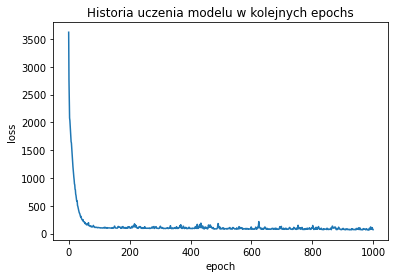

In [36]:
fig, ax = plt.subplots()

ax.plot(history.epoch, history.history.get("loss"))
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_title("Historia uczenia modelu w kolejnych epochs")

fig.show()

Jaka jest ostatnia wartości funkcji ryzyka w procesie treningowym?

In [37]:
history.history.get("loss")[-1]

68.72962951660156

# Porównanie wyników sieci neuronowej oraz klasycznej metody najmniejszych kwadratów

Przypomnijmy sobie model matematyczny, który posłużył nam do symulacji danych.

* $\beta = (150, -4, 2.5, 0, 1)$,
* $X_1 \sim \mathcal{N}(100, 10)$,
* $X_2 \sim \mathcal{N}(50, 5)$,
* $X_3 \sim \mathcal{N}(200, 20)$,
* $\epsilon \sim \mathcal{N}(0, 5)$.

Dopasujmy "klasyczny" model regresji liniowej, używając pakietu `scikit-learn`.

In [38]:
from sklearn.linear_model import LinearRegression

In [39]:
lr = LinearRegression()

lr.fit(data.loc[:, ["X1", "X2", "X3"]].values, data.Y.values)

print(f"intercept: {lr.intercept_}\nX1: {lr.coef_[0]}\nX2: {lr.coef_[1]}\nX3: {lr.coef_[2]}")

intercept: 150.49647704068786
X1: -3.9717967370770633
X2: 2.4709267469227982
X3: -0.011445898962879397


Jaka jest wartość funkcji ryzyka w klasycznym modelu regresji liniowej?

Porównaj MSE z sieci neuronowej oraz to z modelu liniowego.

In [40]:
np.average(
    (
        model4.predict(data.loc[:, ["X1", "X2", "X3"]]) 
        - data.Y.values[:, np.newaxis]
     )**2
)

4/4 [==============================] - 0s 2ms/step


65.79327347157789

In [41]:
np.average(
    (lr.predict(data.loc[:, ["X1", "X2", "X3"]].values) - data.Y.values)**2
)

21.508712718919238

# Możemy próbować innych ustawień algorytmu ADAM

In [42]:
model5 = tf.keras.Sequential()

model5.add(tf.keras.Input(shape=(3,)))

model5.add(tf.keras.layers.Dense(
    1, 
    activation=tf.keras.activations.linear, 
    kernel_initializer=tf.keras.initializers.Constant(random_tensor)
))

model5.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.9), loss='mse')

In [43]:
history = model5.fit(data.loc[:, ["X1", "X2", "X3"]], data.loc[:, ["Y"]], epochs=1000, batch_size=25, verbose=0)

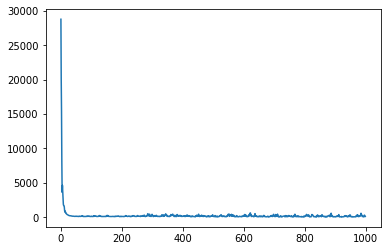

In [44]:
fig, ax = plt.subplots()

ax.plot(history.epoch, history.history.get("loss"))

fig.show()

In [45]:
history.history.get("loss")[-1]

110.47066497802734